In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import os

import pandas as pd

In [2]:
%matplotlib inline

In [3]:
def get_dir_res(dirname):
    gnn_results, cfgnn_results = defaultdict(list), defaultdict(list)
    for fname in os.listdir(dirname):
        with open(os.path.join(dirname, fname), "rb") as f:
            res = pkl.load(f)
            splits = fname.split("_")
            name = splits[0]
            alpha = 0.1
            if "alpha" in splits:
                alpha_idx = splits.index("alpha")
                alpha = float(splits[alpha_idx + 1][:-4]) # exclude .pkl

            for run_id, result in res.items():
                gnn_results[name].append(dict(
                    run_id=run_id,
                    alpha=alpha,
                    model="gnn",
                    **result["gnn"]
                ))
                cfgnn_results[name].append(dict(
                    run_id=run_id,
                    alpha=alpha,
                    model="conf_gnn",
                    **result["conf_gnn"]
                ))
    
    assert gnn_results.keys() == cfgnn_results.keys(), f"Dataset mismatch between gnn and cfgnn models"
    return {dataset: gnn_results[dataset] + cfgnn_results[dataset] for dataset in gnn_results.keys()}

new_aps_results = get_dir_res("pred/script_expt/new_aps/")
old_aps_results = get_dir_res("pred/script_expt/old_aps/")

assert new_aps_results.keys() == old_aps_results.keys(), f"Dataset mismatch between old and new aps methods"


In [4]:
datasets = new_aps_results.keys()
res_ours = {d: pd.DataFrame(new_aps_results[d]) for d in datasets}
res_old = {d: pd.DataFrame(old_aps_results[d]) for d in datasets}

for d in datasets:
    res_ours[d]["aps_method"] = "fixed"
    res_old[d]["aps_method"] = "cfgnn"

res = {d: pd.concat([res_ours[d], res_old[d]]) for d in datasets}

In [5]:
for d in datasets:
    res[d]["aps_eff"] = res[d]["APS"].apply(lambda x: x[1])
    res[d]["aps_cov"] = res[d]["APS"].apply(lambda x: x[0])
    res[d]["raps_eff"] = res[d]["RAPS"].apply(lambda x: x[1])
    res[d]["raps_cov"] = res[d]["RAPS"].apply(lambda x: x[0])
    res[d]["target_cov"] = 1 - res[d]["alpha"]

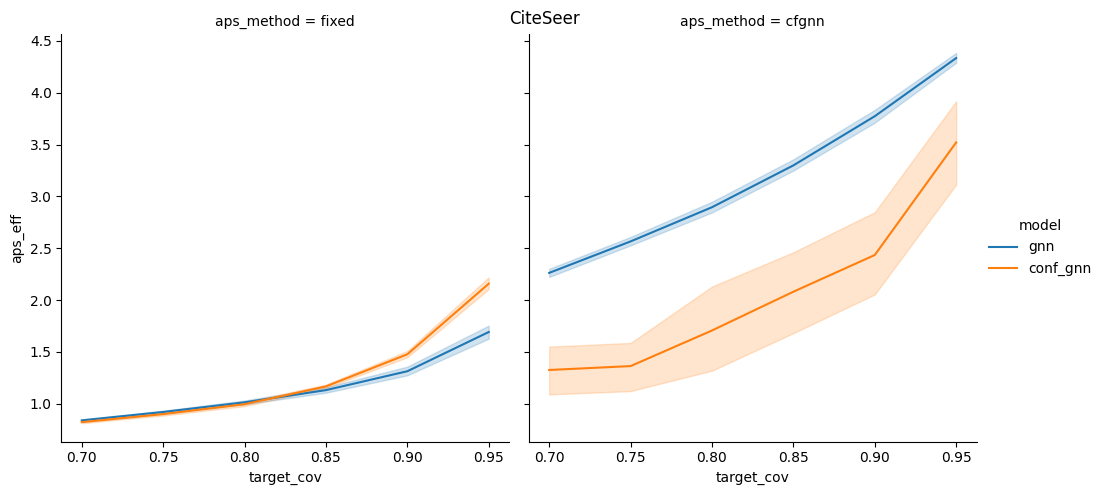

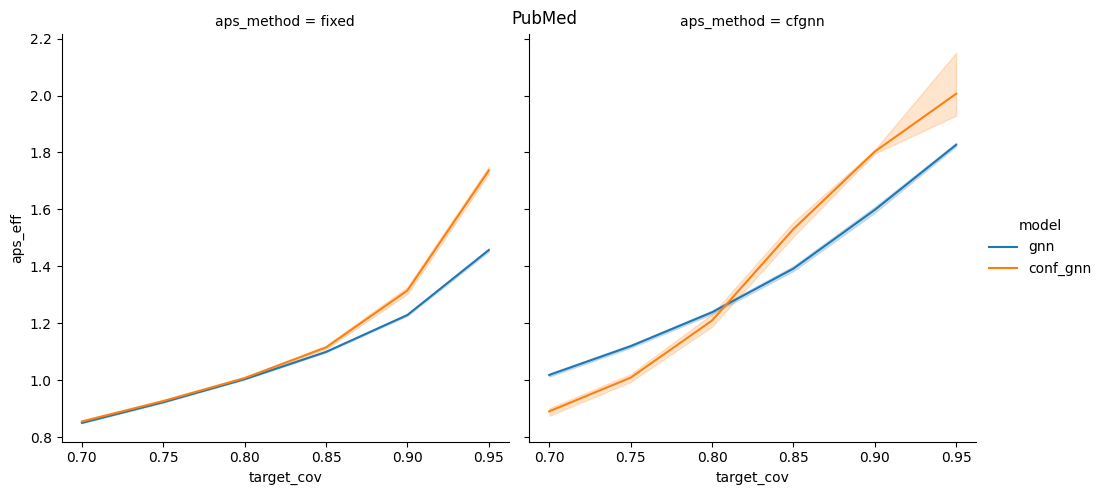

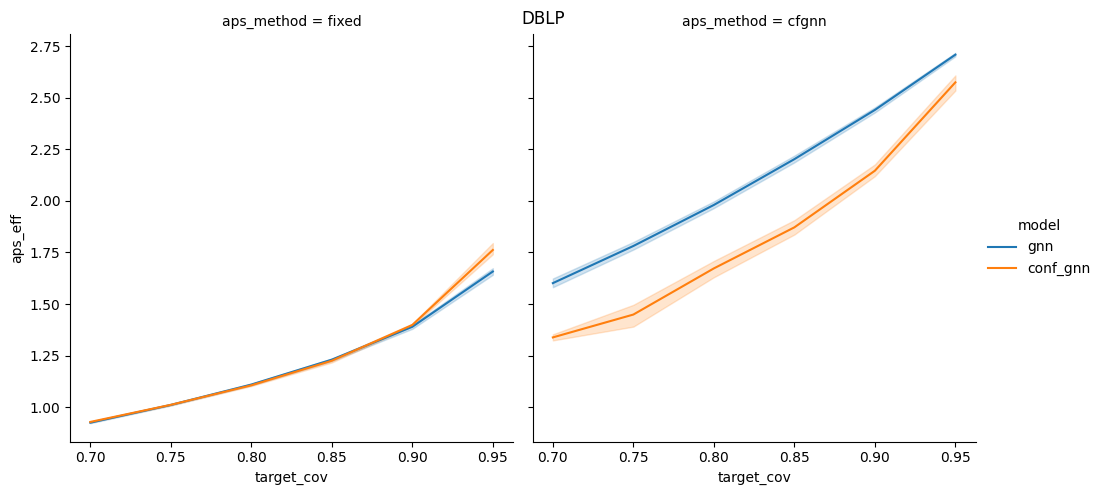

In [7]:
for d in datasets:
    rel = sns.relplot(res[d], x="target_cov", y="aps_eff", hue="model", col="aps_method", kind="line")
    rel.fig.suptitle(d)

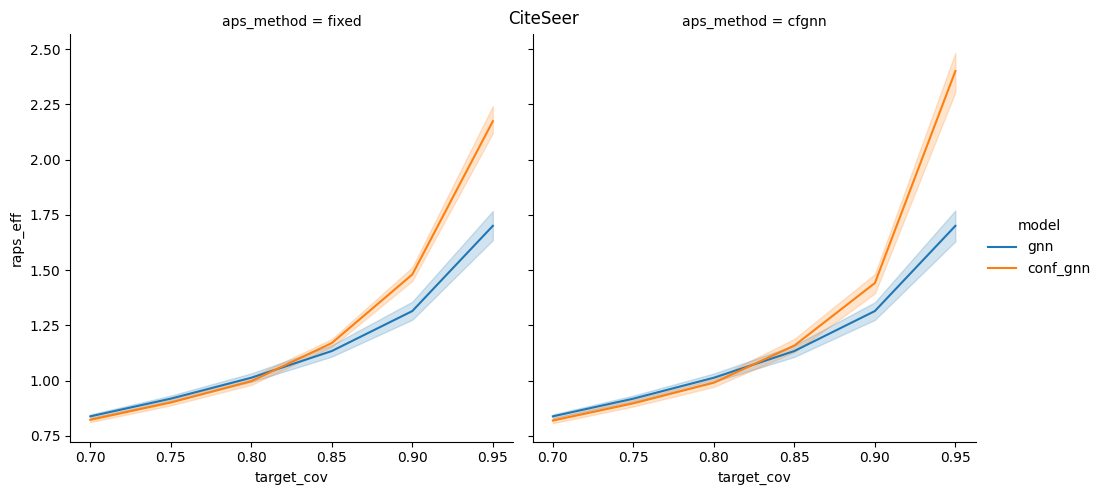

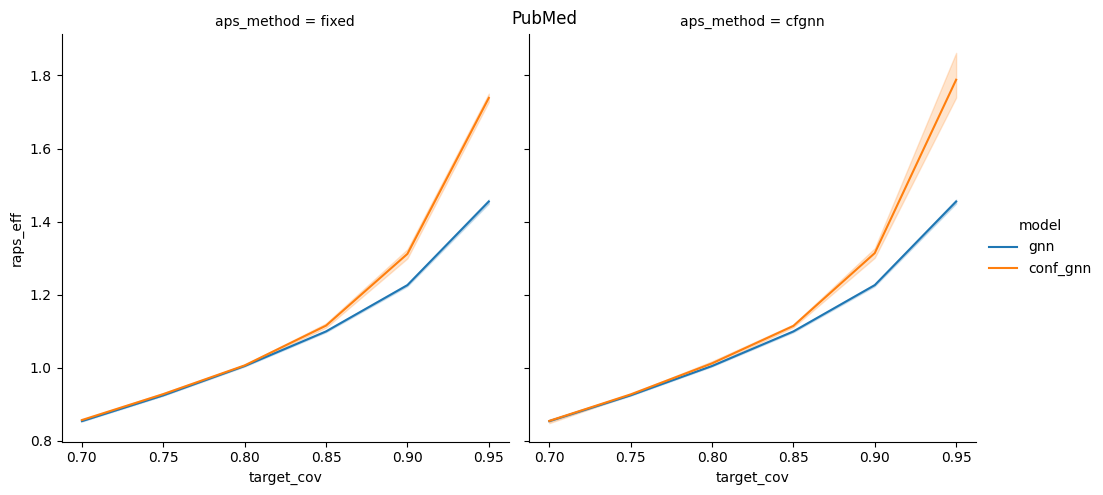

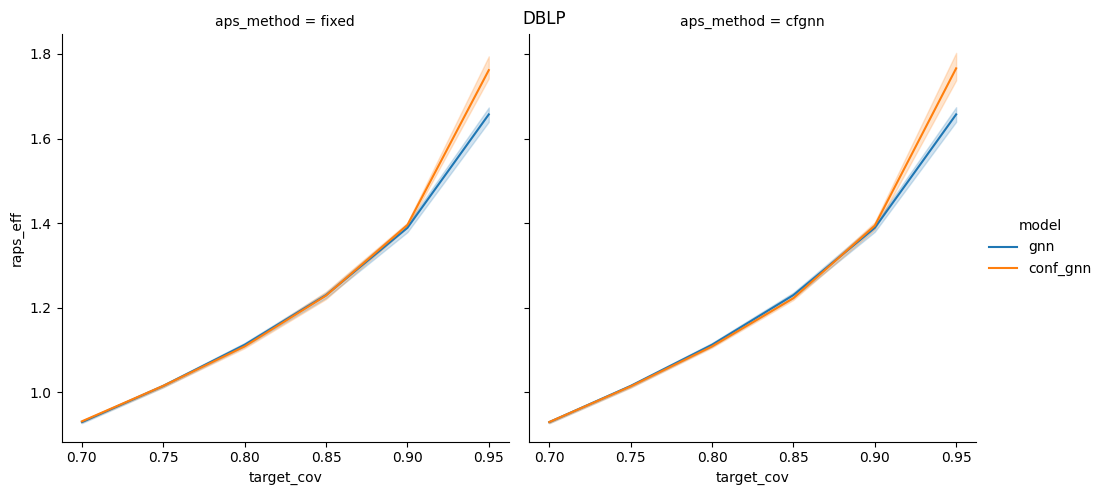

In [8]:
for d in datasets:
    rel = sns.relplot(res[d], x="target_cov", y="raps_eff", hue="model", col="aps_method", kind="line")

    rel.fig.suptitle(d)

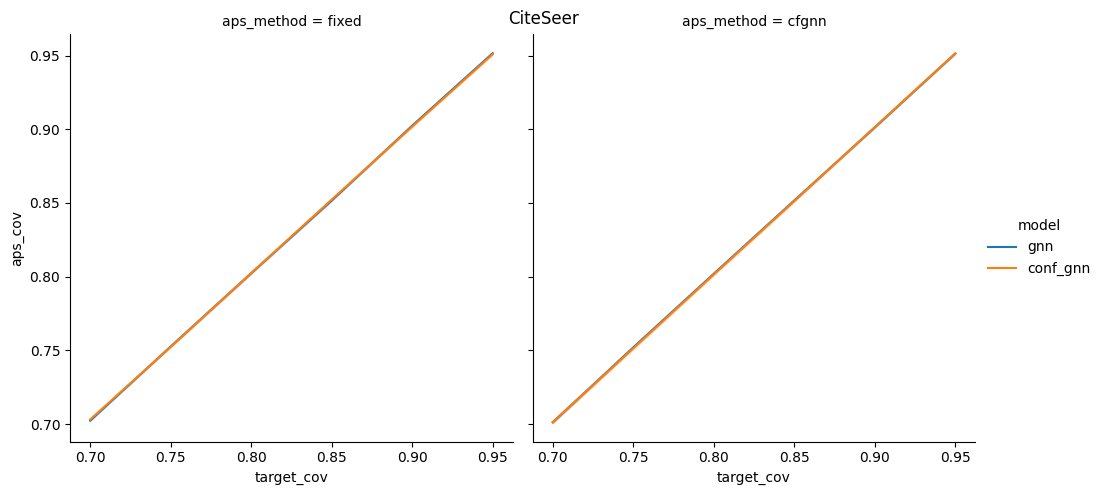

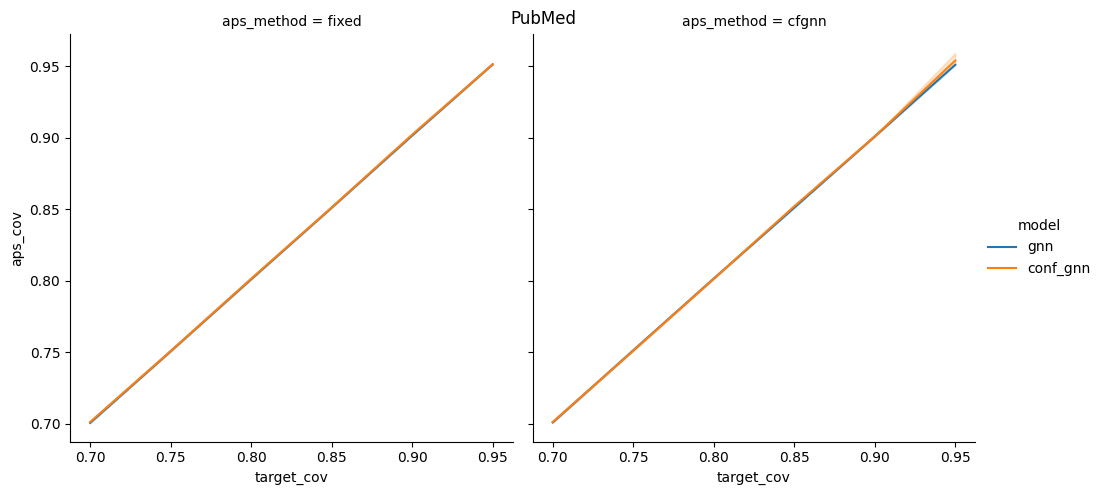

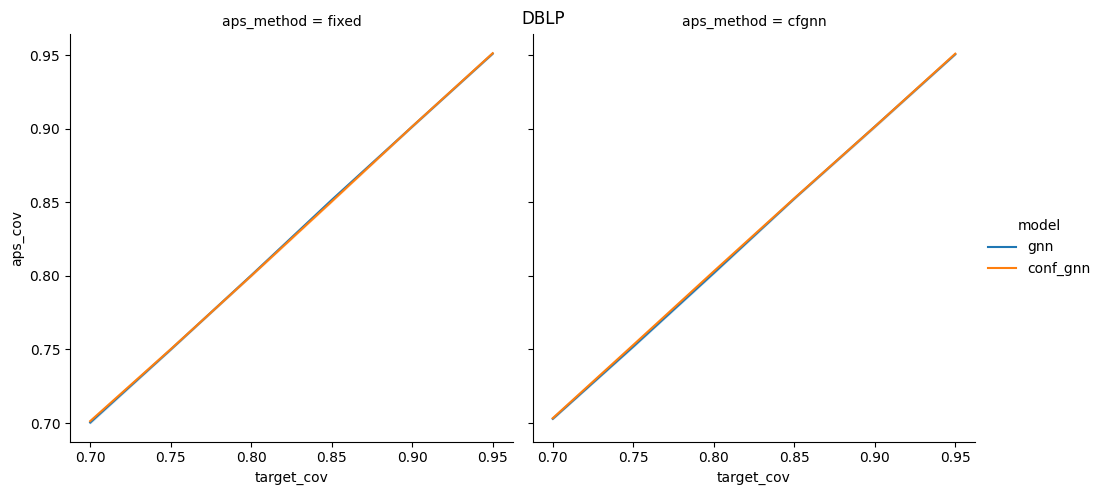

In [10]:
for d in datasets:
    rel = sns.relplot(res[d], x="target_cov", y="aps_cov", hue="model", col="aps_method", kind="line")
    rel.fig.suptitle(d)